First step in the predictor is to load all the data we have now. This is the constructed graph, the topogolical features file for the drug nodes present in the network, and the DDI_filtered and negatives_filtered. 

In [1]:
import networkx as nx
import csv
import pickle
import sklearn as sk
import matplotlib.pyplot as plt
import numpy as np
import rdkit
import seaborn as sns
sns.set_style("ticks")

from imblearn.under_sampling import NearMiss, RandomUnderSampler
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.feature_extraction import FeatureHasher
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay , accuracy_score, auc, roc_curve, RocCurveDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import KernelPCA, TruncatedSVD

from rdkit import Chem
from rdkit.Chem import RDKFingerprint
from rdkit.Chem import rdMolDescriptors

GRAPH_PATH = "networks/weighted_dppi_2024-04-11-23:39:20.graphml"
DDI_PATH = "data/DDIs_filtered.csv"
NEGATIVES_PATH = "data/negatives_filtered.csv"
FILTERED_NEGATIVES_PATH = "filtered_negatives_pckle"
DRUG_TOPOLOGICAL_FEATURES_PATH = "node_features_weighted_2024-05-09-21:43:25"
DRUG_TOPOLOGICAL_FEATURES_UNWEIGHTED_PATH = "node_features_2024-05-09-21:29:57"
DRUG_TOPOLOGICAL_BIOLOGICAL_FEATURES_PATH = "drug_topological_biological_features_pckle"

DRUG_TOP_FEATURE_COUNT = 6

SMILES_CHARS = [' ',
                '#', '%', '(', ')', '+', '-', '.', '/',
                '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                '=', '@',
                'A', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P',
                'R', 'S', 'T', 'V', 'X', 'Z',
                '[', '\\', ']',
                'a', 'b', 'c', 'e', 'g', 'i', 'l', 'n', 'o', 'p', 'r', 's',
                't', 'u']

RANDOM_STATE = 19990605

In [49]:
smi2index = dict( (c,i) for i,c in enumerate( SMILES_CHARS ) )
index2smi = dict( (i,c) for i,c in enumerate( SMILES_CHARS ) )

def smiles_encoder( smiles, maxlen=120 ):
    X = np.zeros( ( maxlen, len( SMILES_CHARS ) ) )
    for i, c in enumerate( smiles ):
        X[i, smi2index[c] ] = 1
    return X

def smiles_decoder( X ):
    smi = ''
    X = X.argmax( axis=-1 )
    for i in X:
        smi += index2smi[ i ]
    return smi

In [50]:
DTPPI_graph: nx.Graph = nx.read_graphml(GRAPH_PATH)
DDI_list = []
negatives_list = []
drug_features_dict = None
drug_features_unweigted_dict = None

with open(DDI_PATH, "r") as ddi_file:
    reader = csv.reader(ddi_file)
    for row in reader:
        DDI_list.append({"drug1": row[0], "drug2": row[1]})
    
# with open(NEGATIVES_PATH, "r") as negatives_file:
#     reader = csv.reader(negatives_file)
#     for row in reader:
#         negatives_list.append({"drug1": row[0], "drug2": row[1]})

with open(FILTERED_NEGATIVES_PATH, "rb") as negatives_file:
    negatives_list = pickle.load(negatives_file)

with open(DRUG_TOPOLOGICAL_FEATURES_PATH, "rb") as drug_features_file:
    drug_features_dict = pickle.load(drug_features_file)

with open(DRUG_TOPOLOGICAL_FEATURES_UNWEIGHTED_PATH, "rb") as drug_unweighted_file:
    drug_features_unweigted_dict = pickle.load(drug_unweighted_file)

with open(DRUG_TOPOLOGICAL_BIOLOGICAL_FEATURES_PATH, "rb") as drug_features_file:
    drug_features_dict_old = pickle.load(drug_features_file)

# Remove header
DDI_list.remove(DDI_list[0])

In [51]:

for drug in drug_features_dict.keys():
    drug_features_dict[drug]["categories"] = drug_features_dict_old[drug]["categories"]

for drug in drug_features_unweigted_dict.keys():
    drug_features_unweigted_dict[drug]["categories"] = drug_features_dict_old[drug]["categories"]

In [52]:
print("DDIs length: " + str(len(DDI_list)))
print("Negatives length: " + str(len(negatives_list)))
print("Drug nodes feature length " + str(len(drug_features_dict)))

DDIs length: 720172
Negatives length: 4037
Drug nodes feature length 3263


A small bonus step, make sure the reliable negatives do not occur in the DDI dataset

In [6]:
# filtered_negatives = []
# iter_number = 0
# for negative in negatives_list:
#     print("now on: " + str(iter_number))
#     present = False
#     for ddi in DDI_list:
#         if (negative["drug1"] == ddi["drug1"] and negative["drug2"] == ddi["drug2"]) or (negative["drug1"] == ddi["drug2"] and negative["drug2"] == ddi["drug1"]):
#             present = True
#             break
    
#     if not present:
#         filtered_negatives.append(negative)
    
#     iter_number += 1

# print(len(negatives_list))
# print(len(filtered_negatives))

# negatives_list = filtered_negatives

In [7]:
# with open("filtered_negatives_pckle", "wb") as filtered_negatives_pickle:
#     pickle.dump(filtered_negatives, filtered_negatives_pickle)

Now we must construct our dataset in such a way that we have a tuple containing : DDI_name, DDI_features, and 1 or 0 for if there is an actual DDI, additional we will undersample the majority class in this data set, because the is a greate imbalance between interactions and non interactions.

In [8]:
def get_link_level_features(save: bool):
    ddi_link_features = {}
    negatives_link_features = {}

    # nx.common_neighbors

    # # print("creating link features for ddis")
    # # for ddi in DDI_list:
    # #     drug1 = ddi["drug1"]
    # #     drug2 = ddi["drug2"]
    # #     ddi_link_features[drug1 + "_" + drug2] = {
    # #         "shortest_distance": nx.shortest_path_length(DTPPI_graph, source=drug1, target=drug2, weight="weight"),
    # #         "number_common_neighbours": sum(1 for _ in nx.common_neighbors(DTPPI_graph, u=drug1, v=drug2))
    # #     }
    
    # print("creating link features for negatives")
    # for negative in DDI_list:
    #     drug1 = negative["drug1"]
    #     drug2 = negative["drug2"]
    #     negatives_link_features[drug1 + "_" + drug2] = {
    #         "shortest_distance": nx.shortest_path_length(DTPPI_graph, source=drug1, target=drug2, weight="weight"),
    #         "number_common_neighbours": sum(1 for _ in nx.common_neighbors(DTPPI_graph, u=drug1, v=drug2))
    #     }

    temp = {}
    for data in nx.all_pairs_shortest_path_length(DTPPI_graph, 5):
        temp[data[0]] = data[1]
    
    ddi_link_features["shortest_distance_5_cutoff"] = temp

    if save:
        # with open("ddi_link_features_pckle", "wb") as ddi_link_file:
        #     pickle.dump(ddi_link_features, ddi_link_file)
        
        with open("link_features_pckle", "wb") as link_features_file:
            pickle.dump(ddi_link_features, link_features_file)


    return ddi_link_features

In [7]:
# Get some info about DB0001 feature dict

drug_features_dict["DB00001"]

{'degree_weighted': 0.3231297433376312,
 'clustering_coefficient': 0,
 'katz_centrality': 0.006457547466583713,
 'closeness_centrality': 0.2477294339778663,
 'degree_centrality': 5.5632823365785815e-05,
 'page_rank': 1.1097509841827928e-05,
 'categories': ['Amino Acids, Peptides, and Proteins',
  'Anticoagulants',
  'Antithrombin Proteins',
  'Antithrombins',
  'Blood and Blood Forming Organs',
  'Cardiovascular Agents',
  'Enzyme Inhibitors',
  'Fibrin Modulating Agents',
  'Hematologic Agents',
  'Peptides',
  'Protease Inhibitors',
  'Proteins',
  'Serine Protease Inhibitors',
  'Serpins',
  'Thrombin Inhibitors']}

In [8]:
drug_features_unweigted_dict["DB00001"]

{'degree_weighted': 1,
 'clustering_coefficient': 0,
 'katz_centrality': 0.0007419247216398986,
 'closeness_centrality': 0.2477294339778663,
 'degree_centrality': 5.5632823365785815e-05,
 'page_rank': 1.113710731678335e-05,
 'categories': ['Amino Acids, Peptides, and Proteins',
  'Anticoagulants',
  'Antithrombin Proteins',
  'Antithrombins',
  'Blood and Blood Forming Organs',
  'Cardiovascular Agents',
  'Enzyme Inhibitors',
  'Fibrin Modulating Agents',
  'Hematologic Agents',
  'Peptides',
  'Protease Inhibitors',
  'Proteins',
  'Serine Protease Inhibitors',
  'Serpins',
  'Thrombin Inhibitors']}

In [9]:
degree_weighted_arr = []
clustering_coff_arr = []
katz_centr_arr = []
closeness_centr_arr = []
degree_centr_arr = []
page_rank_arr = []

drug_index = []

for drug in drug_features_dict.keys():
    # degree_weighted_arr.append((drug, drug_features_dict[drug]["degree_weighted"])) 
    # clustering_coff_arr.append((drug, drug_features_dict[drug]["clustering_coefficient"])) 
    # katz_centr_arr.append((drug, drug_features_dict[drug]["katz_centrality"])) 
    # closeness_centr_arr.append((drug, drug_features_dict[drug]["closeness_centrality"])) 
    # degree_centr_arr.append((drug, drug_features_dict[drug]["degree_centrality"])) 
    # page_rank_arr.append((drug, drug_features_dict[drug]["page_rank"])) 

    degree_weighted_arr.append(drug_features_dict[drug]["degree_weighted"])
    clustering_coff_arr.append(drug_features_dict[drug]["clustering_coefficient"])
    katz_centr_arr.append(drug_features_dict[drug]["katz_centrality"])
    closeness_centr_arr.append(drug_features_dict[drug]["closeness_centrality"])
    degree_centr_arr.append(drug_features_dict[drug]["degree_centrality"])
    page_rank_arr.append(drug_features_dict[drug]["page_rank"]) 

    drug_index.append(drug)

print("done")

degree_weighted_arr_2 = []
clustering_coff_arr_2 = []
katz_centr_arr_2 = []
closeness_centr_arr_2 = []
degree_centr_arr_2 = []
page_rank_arr_2 = []

drug_index_2 = []

for drug in drug_features_unweigted_dict.keys():
    # degree_weighted_arr.append((drug, drug_features_dict[drug]["degree_weighted"])) 
    # clustering_coff_arr.append((drug, drug_features_dict[drug]["clustering_coefficient"])) 
    # katz_centr_arr.append((drug, drug_features_dict[drug]["katz_centrality"])) 
    # closeness_centr_arr.append((drug, drug_features_dict[drug]["closeness_centrality"])) 
    # degree_centr_arr.append((drug, drug_features_dict[drug]["degree_centrality"])) 
    # page_rank_arr.append((drug, drug_features_dict[drug]["page_rank"])) 

    degree_weighted_arr_2.append(drug_features_unweigted_dict[drug]["degree_weighted"])
    clustering_coff_arr_2.append(drug_features_unweigted_dict[drug]["clustering_coefficient"])
    katz_centr_arr_2.append(drug_features_unweigted_dict[drug]["katz_centrality"])
    closeness_centr_arr_2.append(drug_features_unweigted_dict[drug]["closeness_centrality"])
    degree_centr_arr_2.append(drug_features_unweigted_dict[drug]["degree_centrality"])
    page_rank_arr_2.append(drug_features_unweigted_dict[drug]["page_rank"]) 

    drug_index_2.append(drug)

print("done")

done
done


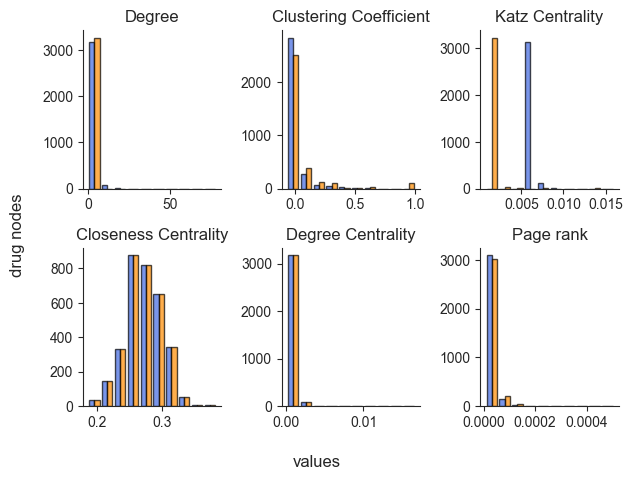

In [47]:
fig, axs = plt.subplots(2, 3)
axs[0, 0].hist([degree_weighted_arr, degree_centr_arr_2], bins=10, color=['royalblue', 'darkorange'], edgecolor='black', alpha=0.7)
axs[0, 0].set_title("Degree")
axs[0, 1].hist([clustering_coff_arr, clustering_coff_arr_2], bins=10, color=['royalblue', 'darkorange'], edgecolor='black', alpha=0.7)
axs[0, 1].set_title("Clustering Coefficient")
axs[0, 2].hist([katz_centr_arr, katz_centr_arr_2], bins=10,color=['royalblue', 'darkorange'], edgecolor='black', alpha=0.7)
axs[0, 2].set_title("Katz Centrality")
axs[1, 0].hist([closeness_centr_arr, closeness_centr_arr_2], bins=10, color=['royalblue', 'darkorange'], edgecolor='black', alpha=0.7)
axs[1, 0].set_title("Closeness Centrality")
axs[1, 1].hist([degree_centr_arr, degree_centr_arr_2], bins=10, color=['royalblue', 'darkorange'], edgecolor='black', alpha=0.7)
axs[1, 1].set_title("Degree Centrality")
axs[1, 2].hist([page_rank_arr, page_rank_arr_2], bins=10, color=['royalblue', 'darkorange'], edgecolor='black', alpha=0.7)
axs[1, 2].set_title("Page rank")

fig.supxlabel('values')
fig.supylabel('drug nodes')
fig.set_label(['hu', 'h'])

fig.tight_layout()
sns.despine()

In [35]:
degree_weighted_arr = []
clustering_coff_arr = []
katz_centr_arr = []
closeness_centr_arr = []
degree_centr_arr = []
page_rank_arr = []

drug_index = []

for drug in drug_features_unweigted_dict.keys():
    # degree_weighted_arr.append((drug, drug_features_dict[drug]["degree_weighted"])) 
    # clustering_coff_arr.append((drug, drug_features_dict[drug]["clustering_coefficient"])) 
    # katz_centr_arr.append((drug, drug_features_dict[drug]["katz_centrality"])) 
    # closeness_centr_arr.append((drug, drug_features_dict[drug]["closeness_centrality"])) 
    # degree_centr_arr.append((drug, drug_features_dict[drug]["degree_centrality"])) 
    # page_rank_arr.append((drug, drug_features_dict[drug]["page_rank"])) 

    degree_weighted_arr.append(drug_features_unweigted_dict[drug]["degree_weighted"])
    clustering_coff_arr.append(drug_features_unweigted_dict[drug]["clustering_coefficient"])
    katz_centr_arr.append(drug_features_unweigted_dict[drug]["katz_centrality"])
    closeness_centr_arr.append(drug_features_unweigted_dict[drug]["closeness_centrality"])
    degree_centr_arr.append(drug_features_unweigted_dict[drug]["degree_centrality"])
    page_rank_arr.append(drug_features_unweigted_dict[drug]["page_rank"]) 

    drug_index.append(drug)

print("done")

done


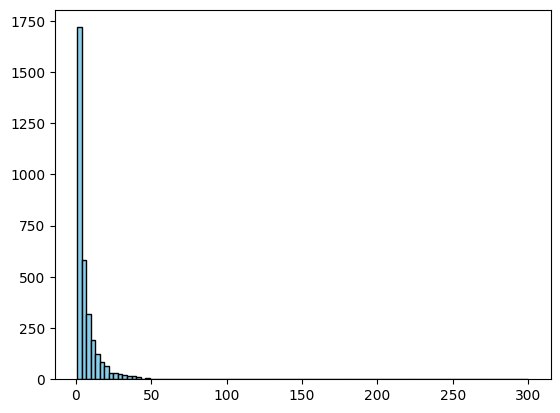

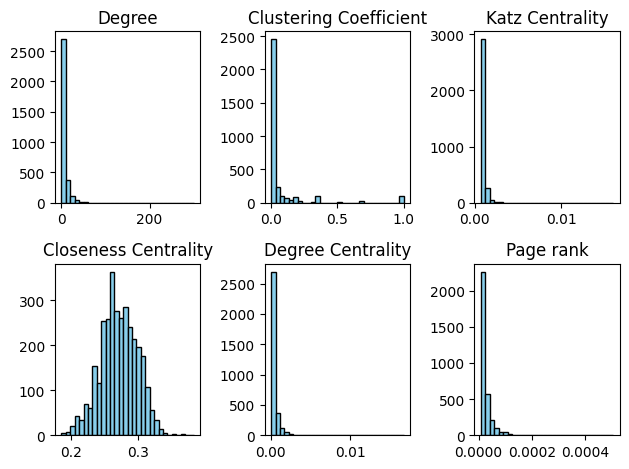

In [36]:
fig, axs = plt.subplots(2, 3)
axs[0, 0].hist(degree_weighted_arr, bins=30, color='skyblue', edgecolor='black')
axs[0, 0].set_title("Degree")
axs[0, 1].hist(clustering_coff_arr, bins=30, color='skyblue', edgecolor='black')
axs[0, 1].set_title("Clustering Coefficient")
axs[0, 2].hist(katz_centr_arr, bins=30, color='skyblue', edgecolor='black')
axs[0, 2].set_title("Katz Centrality")
axs[1, 0].hist(closeness_centr_arr, bins=30, color='skyblue', edgecolor='black')
axs[1, 0].set_title("Closeness Centrality")
axs[1, 1].hist(degree_centr_arr, bins=30, color='skyblue', edgecolor='black')
axs[1, 1].set_title("Degree Centrality")
axs[1, 2].hist(page_rank_arr, bins=30, color='skyblue', edgecolor='black')
axs[1, 2].set_title("Page rank")
fig.tight_layout()

In [53]:
def create_dataset():
    tuple_list = []

    # ddi_link_features, negatives_link_features = get_link_level_features(save=True)

    for ddi in DDI_list:
        drug1 = ddi["drug1"]
        drug2 = ddi["drug2"]

        features_drug1 = list(drug_features_dict[drug1].values())
        features_drug2 = list(drug_features_dict[drug2].values())

        top_features_drug1 = features_drug1[:DRUG_TOP_FEATURE_COUNT]
        bio_features_drug1 = features_drug1[DRUG_TOP_FEATURE_COUNT]
        top_features_drug2 = features_drug2[:DRUG_TOP_FEATURE_COUNT]
        bio_features_drug2 = features_drug2[DRUG_TOP_FEATURE_COUNT]
        # link_features_drug1_drug2 = list(ddi_link_features[drug1 + "_" + drug2].values())

        tuple_list.append((
            drug1 + "_" + drug2,
            # tuple(list(map(lambda x, y: ((x + y) / 2), features_drug1, features_drug2))),
            tuple(top_features_drug1 + top_features_drug2 + bio_features_drug1 + bio_features_drug2),
            1
        ))
    
    for negative in negatives_list:
        drug1 = negative["drug1"]
        drug2 = negative["drug2"]

        features_drug1 = list(drug_features_dict[drug1].values())
        features_drug2 = list(drug_features_dict[drug2].values())

        top_features_drug1 = features_drug1[:DRUG_TOP_FEATURE_COUNT]
        bio_features_drug1 = features_drug1[DRUG_TOP_FEATURE_COUNT]
        top_features_drug2 = features_drug2[:DRUG_TOP_FEATURE_COUNT]
        bio_features_drug2 = features_drug2[DRUG_TOP_FEATURE_COUNT]

        tuple_list.append((
            str(negative["drug1"]) + "_" + str(negative["drug2"]),
            # tuple(list(map(lambda x, y: ((x + y) / 2), features_drug1, features_drug2))),
            tuple(top_features_drug1 + top_features_drug2 + bio_features_drug1 + bio_features_drug2),
            0
        ))
    
    return tuple_list

dataset = create_dataset()

print(len(dataset))

724209


Our data set is now a list of tuples consiting of an ID, feature tuple and class (either 1 or 0), we will use imbalanced learn to undersample our majority class (1) so that we have a 1:1 distribution of out classes

In [54]:
X = [list(data[1]) for data in dataset]
y = [data[2] for data in dataset]

print("shape of X: (%s, %s)" % (str(len(X)), str(len(X[0]))))
print("shape of y: (%s, )" % (str(len(y))))
print("class balance: %s" % Counter(y))

# We won't need dataset anymore so clear it 
del dataset



shape of X: (724209, 47)
shape of y: (724209, )
class balance: Counter({1: 720172, 0: 4037})


In [55]:
topological_features = [data[:DRUG_TOP_FEATURE_COUNT*2] for data in X]
biological_features = [data[DRUG_TOP_FEATURE_COUNT*2:] for data in X]

print("shape of topological features: (%s, %s)" % (str(len(topological_features)), str(len(topological_features[0]))))
print("shape of biological features: (%s, %s)" % (str(len(biological_features)), str(len(biological_features[0]))))

shape of topological features: (724209, 12)
shape of biological features: (724209, 35)


In [56]:
scaler = MinMaxScaler(feature_range=(-1,1))

scaler.fit(topological_features)

topological_features = scaler.transform(topological_features)

In [57]:
encoder = FeatureHasher(n_features=24, input_type="string")

encoder.fit(biological_features)

biological_features = (encoder.transform(biological_features)).toarray()

In [58]:
print("shape of Bio features after encoding: (%s, %s)" % (str(len(biological_features)), str(len(biological_features[0]))))

shape of Bio features after encoding: (724209, 24)


Zip the toplogical and biological features back together

In [59]:
print("shape of X: (%s, %s)" % (str(len(topological_features)), str(len(topological_features[0]))))
print("shape of X: (%s, %s)" % (str(len(biological_features)), str(len(biological_features[0]))))

X = np.concatenate((np.array(topological_features),np.array(biological_features)),axis=1)

print("shape of X: (%s, %s)" % (str(len(X)), str(len(X[0]))))


shape of X: (724209, 12)
shape of X: (724209, 24)
shape of X: (724209, 36)


Before we split the data, let's do some preprocessing

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

print("Amount of classes in train: %s" % Counter(y_train))
print("Amount of classes in test: %s" % Counter(y_test))

Amount of classes in train: Counter({1: 576104, 0: 3263})
Amount of classes in test: Counter({1: 144068, 0: 774})


Here we'll assign different datasets based on their features in order to compare performance later on

In [61]:
X_train_bio, X_test_bio = [data[DRUG_TOP_FEATURE_COUNT*2:] for data in X_train], [data[DRUG_TOP_FEATURE_COUNT*2:] for data in X_test]
X_train_top, X_test_top = [data[:DRUG_TOP_FEATURE_COUNT*2] for data in X_train], [data[:DRUG_TOP_FEATURE_COUNT*2] for data in X_test]

Let's scale our features, casue they are quite far apart

In [19]:
# scaler = MinMaxScaler(feature_range=(-1,1))

# scaler.fit([data[:14] for data in X])

# X_train_top = scaler.transform(X_train_top)
# X_test_top =  scaler.transform(X_test_top)

Now let's onehot encode all our categorical features

In [20]:
# enc = MultiLabelBinarizer()

# enc.fit([tuple(data[14:]) for data in X])

# X_train_bio = enc.transform(X_train_bio)
# X_test_bio = enc.transform(X_test_bio)

In [21]:
# len(list(enc.classes_))

Let's undersample both our train sets

In [62]:
# nm = NearMiss()
# X_train, y_train = nm.fit_resample(X=X_train, y=y_train)

rus = RandomUnderSampler(sampling_strategy=1, random_state=RANDOM_STATE)

y_train_temp_bio = y_train
y_train_temp_top = y_train

X_train_bio, y_train_temp_bio = rus.fit_resample(X=X_train_bio, y=y_train_temp_bio)
X_train_top, y_train_temp_top = rus.fit_resample(X=X_train_top, y=y_train_temp_top)

X_train_biotop = np.concatenate((X_train_top, X_train_bio), axis=1)

y_train_biotop = y_train_temp_top

# X_train, y_train = rus.fit_resample(X=X_train, y=y_train)

print("Amount of classes after rebalance in train: %s" % Counter(y_train_biotop))

Amount of classes after rebalance in train: Counter({0: 3263, 1: 3263})


In [63]:
X_test_biotop = np.concatenate((X_test_top, X_test_bio), axis=1)

In [25]:
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# print("size of our X_train: " + str(len(X_train)))
# print("size of our X_val: " + str(len(X_val)))

In [2]:
10.0 ** -np.arange(1, 7)

array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06])

Let's run GridSearchCV to determine our optimal parameters for the MLP classifier

In [26]:
grid_params = {
    'solver': ['adam', 'lbfgs'],
    'hidden_layer_sizes': [(36), (36, 18), (36, 18, 9)],
    'alpha': 10.0 ** -np.arange(1, 7),
    'max_iter': [200, 500, 1000, 2000, 3000]
}

In [ ]:
mlp = MLPClassifier()
clf_bio = GridSearchCV(estimator=mlp, param_grid=grid_params, cv=5)
clf_bio.fit(X_train_bio, y_train_temp_bio)

mlp = MLPClassifier()
clf_top = GridSearchCV(estimator=mlp, param_grid=grid_params, cv=5)
clf_top.fit(X_train_top, y_train_temp_top)

mlp = MLPClassifier()
clf_biotop = GridSearchCV(estimator=mlp, param_grid=grid_params, cv=5)
clf_biotop.fit(X_train_biotop, y_train_biotop)

In [43]:
clf_bio.best_params_
clf_top.best_params_
clf_biotop.best_params_

{'alpha': 0.1, 'hidden_layer_sizes': 36, 'max_iter': 200, 'solver': 'adam'}

In [44]:
clf_bio.best_params_

{'alpha': 0.1, 'hidden_layer_sizes': 36, 'max_iter': 500, 'solver': 'adam'}

In [45]:
clf_top.best_params_

{'alpha': 1e-06,
 'hidden_layer_sizes': (36, 18, 9),
 'max_iter': 2000,
 'solver': 'lbfgs'}

In [110]:
performance = {}

In [65]:
def show_confusion_matrix(y_true, y_predicted, classes):
    cm = confusion_matrix(y_true=y_true, y_pred=y_predicted, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

    disp.plot()
    plt.show()

In [109]:
def predict_with_mlp(X_train, y_train, X_test, y_test, params, name="mlp"):

    mlp = MLPClassifier(solver=params["solver"], alpha=params["alpha"], hidden_layer_sizes=params["hidden_layer_sizes"], max_iter=params["max_iter"], random_state=RANDOM_STATE)
    mlp.fit(X_train, y_train)

    y_pred_train = mlp.predict(X_train)
    y_pred_test = mlp.predict(X_test)

    y_pred_train_proba = mlp.predict_proba(X_train)
    y_pred_test_proba = mlp.predict_proba(X_test)

    performance[name] = {}

    performance[name]["test"] = {
        "accuracy": accuracy_score(y_true=y_test, y_pred=y_pred_test),
        "precision": precision_score(y_true=y_test, y_pred=y_pred_test),
        "recall": recall_score(y_true=y_test, y_pred=y_pred_test),
        "f1": f1_score(y_true=y_test, y_pred=y_pred_test),
        "roc": roc_curve(y_true=y_test, y_score=y_pred_test_proba[:, 1]),
        "roc_disp": RocCurveDisplay.from_estimator(mlp, X_test, y_test)
    }

    performance[name]["train"] = {
        "accuracy": accuracy_score(y_true=y_train, y_pred=y_pred_train),
        "precision": precision_score(y_true=y_train, y_pred=y_pred_train),
        "recall": recall_score(y_true=y_train, y_pred=y_pred_train),
        "f1": f1_score(y_true=y_train, y_pred=y_pred_train),
        "roc": roc_curve(y_true=y_train, y_score=y_pred_train_proba[:, 1]),
        "roc_disp": RocCurveDisplay.from_estimator(mlp, X_train, y_train)
    }

    return y_pred_test, y_pred_train, mlp.classes_

In [67]:
# mlp_params = {
#     "solver": 'lbfgs',
#     "alpha": 1e-05,
#     "hidden_layer_sizes": (36),
#     "max_iter": 2000,
# }

mlp_params = {
    "solver": 'adam',
    "alpha": 0.1,
    "hidden_layer_sizes": (36),
    "max_iter": 500,
}

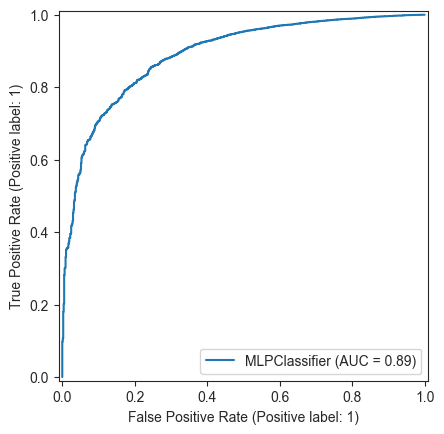

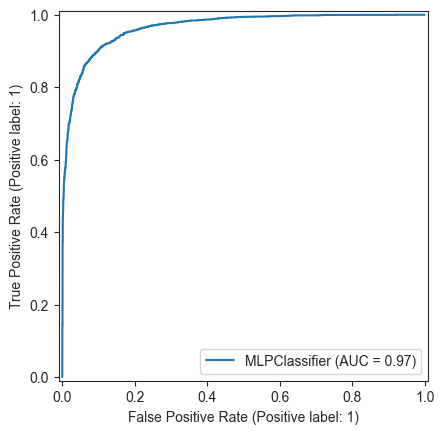

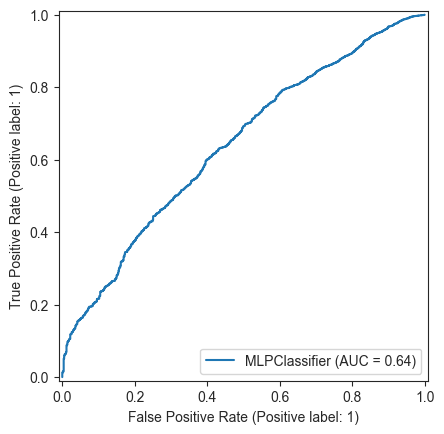

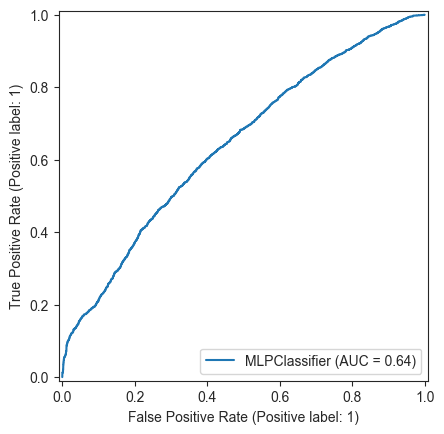

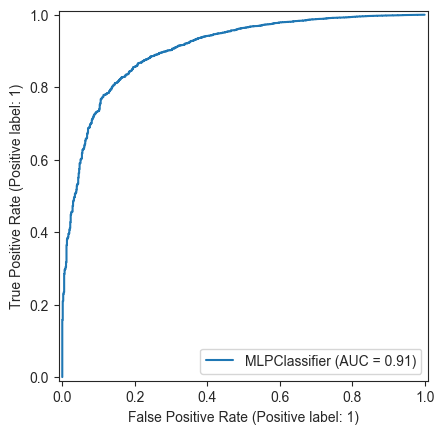

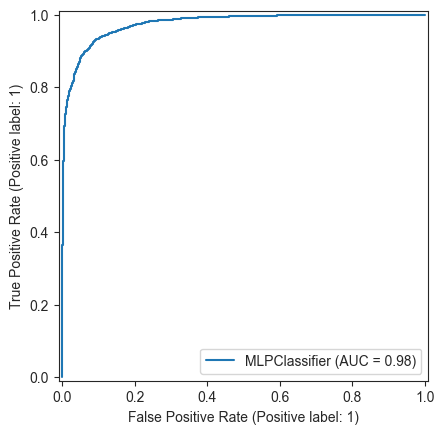

In [111]:
bio_y_pred_test, bio_y_pred_train, classes = predict_with_mlp(X_train_bio, y_train_temp_bio, X_test_bio, y_test, params=mlp_params, name="bio")
top_y_pred_test, top_y_pred_train, classes = predict_with_mlp(X_train_top, y_train_temp_top, X_test_top, y_test, params=mlp_params, name="top")
biotop_y_pred_test, biotop_y_pred_train, classes = predict_with_mlp(X_train_biotop, y_train_biotop, X_test_biotop, y_test, params=mlp_params, name="biotop")

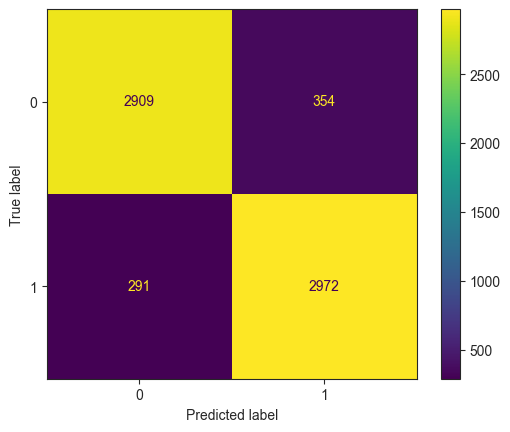

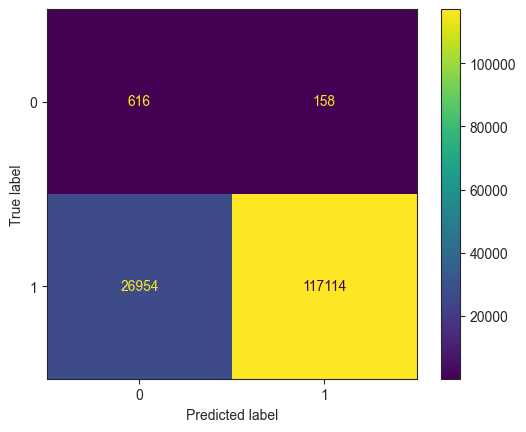

In [74]:
show_confusion_matrix(y_train_temp_bio, bio_y_pred_train, classes)
show_confusion_matrix(y_test, bio_y_pred_test, classes)

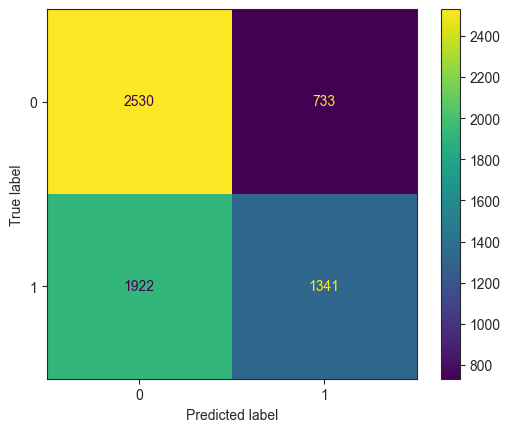

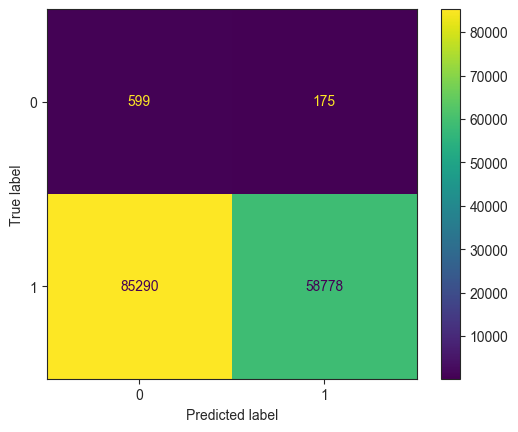

In [75]:
show_confusion_matrix(y_train_temp_top, top_y_pred_train, classes)
show_confusion_matrix(y_test, top_y_pred_test, classes)

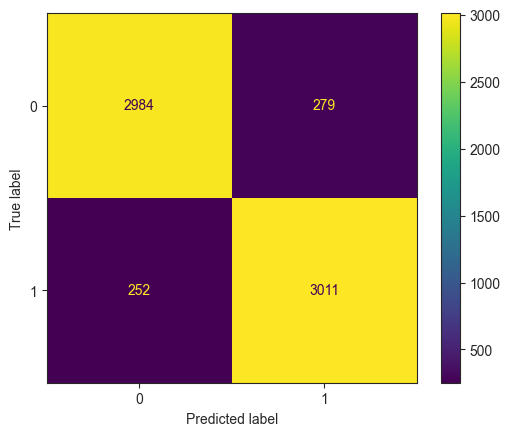

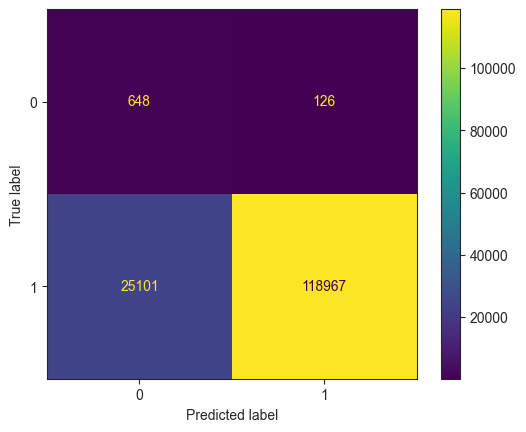

In [76]:
show_confusion_matrix(y_train_biotop, biotop_y_pred_train, classes)
show_confusion_matrix(y_test, biotop_y_pred_test, classes)

In [77]:
performance

{'bio': {'test': {'accuracy': 0.812816724430759,
   'precision': 0.9986527048229756,
   'recall': 0.8129077935419385,
   'f1': 0.8962577485268233,
   'roc': (array([0.        , 0.        , 0.        , ..., 0.99741602, 0.99741602,
           1.        ]),
    array([0.00000000e+00, 6.94116667e-06, 2.08235000e-05, ...,
           9.99972235e-01, 1.00000000e+00, 1.00000000e+00]),
    array([           inf, 9.99999999e-01, 9.99999998e-01, ...,
           4.48052180e-05, 1.40211267e-05, 7.70824489e-07]))},
  'train': {'accuracy': 0.9011645724793135,
   'precision': 0.8935658448586891,
   'recall': 0.9108182653999387,
   'f1': 0.9021095765670056,
   'roc': (array([0.        , 0.        , 0.        , ..., 0.99877413, 0.99938707,
           1.        ]),
    array([0.00000000e+00, 3.06466442e-04, 1.34845234e-02, ...,
           1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
    array([           inf, 9.99999973e-01, 9.99963073e-01, ...,
           1.69500962e-05, 1.63185038e-05, 6.32755387e

In [83]:
print("MLP BIO TEST")

print("accuracy: " + str(performance["bio"]["test"]["accuracy"]))
print("precision: " + str(performance["bio"]["test"]["precision"]))
print("recall: " + str(performance["bio"]["test"]["recall"]))
print("f1: " + str(performance["bio"]["test"]["f1"]))

print("MLP BIO TRAIN")

print("accuracy: " + str(performance["bio"]["train"]["accuracy"]))
print("precision: " + str(performance["bio"]["train"]["precision"]))
print("recall: " + str(performance["bio"]["train"]["recall"]))
print("f1: " + str(performance["bio"]["train"]["f1"]))

MLP BIO TEST
accuracy: 0.812816724430759
precision: 0.9986527048229756
recall: 0.8129077935419385
f1: 0.8962577485268233
MLP BIO TRAIN
accuracy: 0.9011645724793135
precision: 0.8935658448586891
recall: 0.9108182653999387
f1: 0.9021095765670056


In [84]:
print("MLP TOP TEST")

print("accuracy: " + str(performance["top"]["test"]["accuracy"]))
print("precision: " + str(performance["top"]["test"]["precision"]))
print("recall: " + str(performance["top"]["test"]["recall"]))
print("f1: " + str(performance["top"]["test"]["f1"]))

print("MLP TOP TRAIN")

print("accuracy: " + str(performance["top"]["train"]["accuracy"]))
print("precision: " + str(performance["top"]["train"]["precision"]))
print("recall: " + str(performance["top"]["train"]["recall"]))
print("f1: " + str(performance["top"]["train"]["f1"]))

MLP TOP TEST
accuracy: 0.4099432485052678
precision: 0.9970315335945584
recall: 0.40798789460532525
f1: 0.5790336960215938
MLP TOP TRAIN
accuracy: 0.5931657983450812
precision: 0.6465766634522662
recall: 0.410971498620901
f1: 0.5025295109612141


In [85]:
print("MLP BIO_TOP TEST")

print("accuracy: " + str(performance["biotop"]["test"]["accuracy"]))
print("precision: " + str(performance["biotop"]["test"]["precision"]))
print("recall: " + str(performance["biotop"]["test"]["recall"]))
print("f1: " + str(performance["biotop"]["test"]["f1"]))

print("MLP BIO_TOP TRAIN")

print("accuracy: " + str(performance["biotop"]["train"]["accuracy"]))
print("precision: " + str(performance["biotop"]["train"]["precision"]))
print("recall: " + str(performance["biotop"]["train"]["recall"]))
print("f1: " + str(performance["biotop"]["train"]["f1"]))

MLP BIO_TOP TEST
accuracy: 0.8258309054003673
precision: 0.9989420033083388
recall: 0.8257697753838465
f1: 0.9041385311653323
MLP BIO_TOP TRAIN
accuracy: 0.9186331596690163
precision: 0.9151975683890577
recall: 0.9227704566349985
f1: 0.9189684114146193


In [86]:
performance["biotop"]["test"]["roc"]

(array([0.        , 0.        , 0.        , ..., 0.99870801, 0.99870801,
        1.        ]),
 array([0.00000000e+00, 6.94116667e-06, 1.57904601e-01, ...,
        9.99986118e-01, 1.00000000e+00, 1.00000000e+00]),
 array([           inf, 1.00000000e+00, 9.98318793e-01, ...,
        3.22390105e-05, 1.18985203e-05, 8.98365821e-06]))

In [97]:
performance["top"]["test"]["roc"][0]

array([0.        , 0.        , 0.        , ..., 0.99870801, 1.        ,
       1.        ])

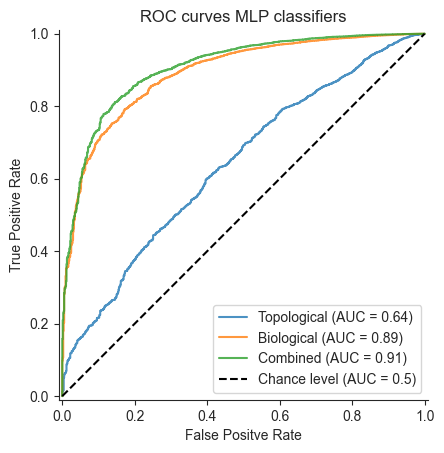

In [125]:
ax = plt.gca()
display_top = performance["top"]["test"]["roc_disp"]
display_bio = performance["bio"]["test"]["roc_disp"]
display_biotop = performance["biotop"]["test"]["roc_disp"]

display_top.plot(ax=ax, alpha=0.8, name="Topological")
display_bio.plot(ax=ax, alpha=0.8, name="Biological")
display_biotop.plot(ax=ax, alpha=0.8, name="Combined", plot_chance_level=True)

ax.set(xlabel="False Positve Rate", ylabel="True Positive Rate", title="ROC curves MLP classifiers")

sns.despine()
plt.show()